In [1]:
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
import numpy as np

**Data Taken From:** https://www.kaggle.com/wordsforthewise/lending-club </br>
**Model is From:** https://www.kaggle.com/benesalvatore/predict-default-using-logisitic-regression

In [2]:
features = ['loan_amnt', 'annual_inc', 'term', 'emp_length']

In [3]:
a = pd.read_csv('accepted_2007_to_2018Q4.csv', usecols=features+['loan_status'])

In [4]:
full_set = a.query("loan_status in ('Fully Paid', 'Charged Off')").copy()

In [5]:
full_set = full_set.dropna(subset=['emp_length'])

# Build the model - Logistic Regression

1. Transform our Label *loan_status* and other columns

In [6]:
full_set['loan_status'] = full_set['loan_status'].replace(
    {
        'Fully Paid': 1,
        'Charged Off': 0
    }
)

full_set['term'] = full_set['term'].replace(
    {
        ' 36 months': 36,
        ' 60 months': 60
    }
)

In [7]:
full_set['emp_length'] = full_set['emp_length'].map(lambda x: x.split(' ')[0])
full_set['emp_length'] = full_set['emp_length'].map(lambda x: str(x).replace('+', '').replace('<', '0'))

**Build Model**

In [8]:
model_features = list(full_set.columns)
model_features.remove('loan_status')

In [13]:
full_set.head()

,loan_amnt,term,emp_length,annual_inc,loan_status
0,3600.0,36,10,55000.0,1
1,24700.0,36,10,65000.0,1
2,20000.0,60,10,63000.0,1
4,10400.0,60,3,104433.0,1
5,11950.0,36,4,34000.0,1


Use train_test_split to split the data into train and test data.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    full_set[model_features],
    full_set['loan_status'],
    random_state=42
)

Set the model as logistic regression.

Set scaler as MinMaxScaler.

In [14]:
model = LogisticRegression()
scaler = MinMaxScaler()

Use pipline to assemble scaler and model as the step.

In [16]:
pipeline = Pipeline([('scaler', scaler), ('model', model)])

train the model.

In [17]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('model', LogisticRegression())])

**Test Model**

Use the train model to predict the test data.

Use roc_cureve to see how efficient the model is and draw it as a graph.

ROC-AUC-score:  0.6200864207569721


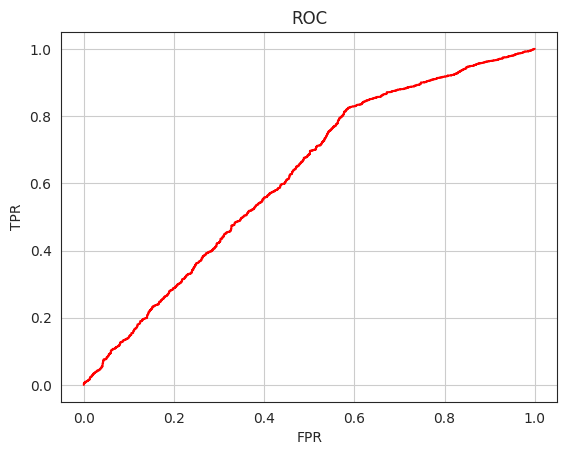

In [18]:
test_probas = pipeline.predict_proba(X_test)[:,1]

fpr, tpr, tresholds = roc_curve(y_test, test_probas)
plt.plot(fpr, tpr, color='red')
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.grid()

print('ROC-AUC-score: ', roc_auc_score(y_test, test_probas))

Create _compute_accuracy_for_thresholds with DataFrame (data) as the input.

Create an array of 100 evenly spaced values for 0 to 1 and store it into thresholds.

Use for loop to loop through each threshold in the array. Then, transforms each predicted probabilities into 0 or 1 based on if it's greater than threshold.
After that, use accuracy_score to calculate the accuracy by comparing labels to the binary predictions.

In [19]:
def _compute_accuracy_for_thresholds(data: pd.core.frame.DataFrame):
    """
    Compute Classifier's Accuracy for various thresholds
    """

    thresholds = np.linspace(0, 1, 100)

    accuracies = []

    for threshold in thresholds:
        preds = data['preds'].map(lambda x: 1 if x > threshold else 0)
        accuracy_ = accuracy_score(data['labels'].values, preds)
        accuracies.append(accuracy_)

    return accuracies, thresholds

Store test_probas into X_test 'preds' column and y_test to X_test 'labels' column.

In [20]:
X_test['preds'] = test_probas
X_test['labels'] = y_test

Call _compute_accuracy_for_thresholds function with X_test as the argument. After the function runs finish, store the return data into accuracies and thresholds.

In [21]:
accuracies, thresholds = _compute_accuracy_for_thresholds(X_test)

Plot the calculated threshold and accurary into a graph.

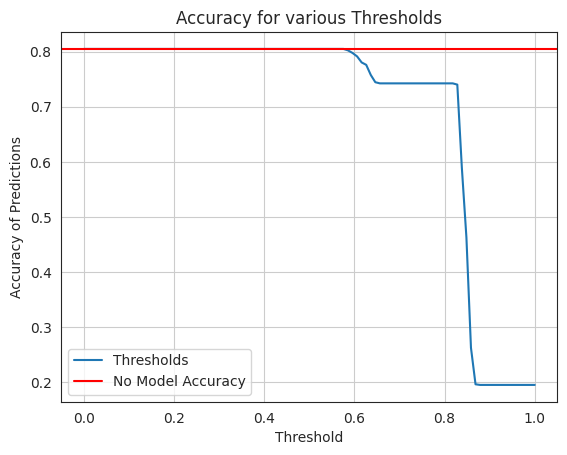

In [22]:
plt.plot(thresholds.reshape(-1, 1), accuracies, label='Thresholds')
plt.axhline(
    (X_test['labels'].sum()) / len(X_test), color='red', label='No Model Accuracy')
plt.grid()
plt.title('Accuracy for various Thresholds')
plt.xlabel('Threshold')
plt.ylabel('Accuracy of Predictions')
plt.legend()
plt.show()

Use accuracy_score to calculate the accuracy of the model

In [23]:
accuracy_score(X_test['labels'].values, list(map(lambda x: 1 if x > 0.7 else 0, X_test['preds'])))

0.7423984891406987

**Save Pipeline**

In [24]:
with open('app/model.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

In [25]:
model = pickle.load(
    open('app/model.pkl', 'rb')
)